In [1]:
import sys
sys.path.append('..')
from Helpers.Helpers import *
from Helpers.Environment import *

import numpy as np
from matplotlib import pyplot as plt


In [91]:
def Linearization(dt,x, u):
    """
    Parameters :
        - x : the state of the system
        - alpha : the body tilt

    return :
        The Jacobian Matrix of the dynamic of the system around the state x
    """

    theta1, theta2, dtheta1, dtheta2 = x[:4]
    C = np.array(
        [
            -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.sin(theta2),
            dtheta1**2 * a2 * np.sin(theta2),
        ]
    )

    dCdte = np.array(
        [
            -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.cos(theta2),
            dtheta1**2 * a2 * np.cos(theta2),
        ]
    )
    dCdos = np.array(
        [-dtheta2 * 2 * a2 * np.sin(theta2), 2 * dtheta1 * a2 * np.sin(theta2)]
    )
    dCdoe = np.array([(-2 * dtheta1 - 2 * dtheta2) * a2 * np.sin(theta2), 0])

    # Inertia matrix
    M = np.array(
        [
            [a1 + 2 * a2 * np.cos(theta2), a3 + a2 * np.cos(theta2)],
            [a3 + a2 * np.cos(theta2), a3],
        ]
    )

    Minv = np.linalg.inv(M)

    dM = np.array(
        [[-2 * a2 * np.sin(theta2), -a2 * np.sin(theta2)], [-a2 * np.sin(theta2), 0]]
    )

    Moment_Arm = np.array([[2, -2, 0, 0, 1.5, -2], [0, 0, 2, -2, 2, -1.5]])

    l0 = np.array([7.32, 3.26, 6.4, 4.26, 5.95, 4.04])
    theta0 = np.array(
        [
            [
                2 * pi / 360 * 15,
                2 * pi / 360 * 4.88,
                0,
                0,
                2 * pi / 360 * 4.5,
                2 * pi / 360 * 2.12,
            ],
            [
                0,
                0,
                2 * pi / 360 * 80.86,
                2 * pi / 360 * 109.32,
                2 * pi / 360 * 92.96,
                2 * pi / 360 * 91.52,
            ],
        ]
    )
    l = 1 + Moment_Arm[0] * (theta0[0] - x[0]) / l0 + Moment_Arm[1] * (theta0[1] - x[1]) / l0
    dldts = -Moment_Arm[0] / l0
    dldte = -Moment_Arm[1] / l0

    v = Moment_Arm[0] * (-x[2]) / l0 + Moment_Arm[1] * (-x[3]) / l0
    dvdos = -Moment_Arm[0] / l0
    dvdoe = -Moment_Arm[1] / l0
    # Equation (6): fl(l)
    fl = np.exp(np.abs((l**1.55 - 1) / 0.81))

    dfldl = (
        fl
        * np.sign((l**1.55 - 1) / 0.81)
        * (1.55 * l**0.55 / 0.81)
    )
    # Equation (7): ff_v(l, v)
    fv = np.where(
        v <= 0,
        (-7.39 - v) / (-7.39 + (-3.21 + 4.17) * v),
        (0.62 - (-3.12 + 4.21 * l - 2.67 * l**2) * v) / (0.62 + v),
    )
    dfvdl = np.where(v <= 0, 0, v * (-4.21 + 5.34 * l) / (0.62 + v))

    dfvdv = np.where(
        v <= 0,
        7.39 * (1 + 0.96) / (-7.39 + 0.96 * v) ** 2,
        0.62 * (-3.12 + 4.21 * l - 2.67 * l**2 - 1) / (0.62 + v) ** 2,
    )

    dfldts = dfldl * dldts
    dfldte = dfldl * dldte
    dfvdts = dfvdl * dldts
    dfvdte = dfvdl * dldte
    dfvdos = dfvdv * dvdos
    dfvdoe = dfvdv * dvdoe

    # Compute acceleration dependencies
    dtheta = np.array([dtheta1, dtheta2])

    d_accel_theta1 = Minv @ (Moment_Arm @ (u * (dfldts * fv + fl * dfvdts)))
    d_accel_dtheta1 = Minv @ (Moment_Arm @ (u * dfvdos * fl) - dCdos - Bdyn @ np.array([1, 0]))
    d_accel_theta2 = -Minv @ (
        dM @ Minv @ (Moment_Arm @ (u * fl * fv) - C - Bdyn @ dtheta)
    ) + Minv @ (Moment_Arm @ (u * (dfldte * fv + fl * dfvdte)) - dCdte)
    d_accel_dtheta2 = Minv @ (Moment_Arm @ (u * dfvdoe * fl) - dCdoe - Bdyn @ np.array([0, 1]))

    # Construct the Jacobian matrix
    A = np.zeros((4, 4))

    A[0, 2] = 1
    A[1, 3] = 1

    # Acceleration contributions
    A[2, 0] = d_accel_theta1[0]
    A[2, 2] = d_accel_dtheta1[0]
    A[2, 1] = d_accel_theta2[0]
    A[2, 3] = d_accel_dtheta2[0]

    A[3, 0] = d_accel_theta1[1]
    A[3, 2] = d_accel_dtheta1[1]
    A[3, 1] = d_accel_theta2[1]
    A[3, 3] = d_accel_dtheta2[1]
    FinalA = np.identity(6)
    FinalA[:4,:4] += dt*A
    return FinalA


def f(x, u):
    C = np.array(
        [-x[3] * (2 * x[2] + x[3]) * a2 * np.sin(x[1]), x[2] ** 2 * a2 * np.sin(x[1])]
    )

    Denominator = a3 * (a1 - a3) - a2**2 * np.cos(x[1]) ** 2
    Minv = np.array(
        [
            [a3 / Denominator, (-a2 * np.cos(x[1]) - a3) / Denominator],
            [
                (-a2 * np.cos(x[1]) - a3) / Denominator,
                (2 * a2 * np.cos(x[1]) + a1) / Denominator,
            ],
        ]
    )
    A = np.array([[2, -2, 0, 0, 1.5, -2], [0, 0, 2, -2, 2, -1.5]])

    l0 = np.array([7.32, 3.26, 6.4, 4.26, 5.95, 4.04])
    theta0 = np.array(
        [
            [
                2 * pi / 360 * 15,
                2 * pi / 360 * 4.88,
                0,
                0,
                2 * pi / 360 * 4.5,
                2 * pi / 360 * 2.12,
            ],
            [
                0,
                0,
                2 * pi / 360 * 80.86,
                2 * pi / 360 * 109.32,
                2 * pi / 360 * 92.96,
                2 * pi / 360 * 91.52,
            ],
        ]
    )
    l = 1 + A[0] * (theta0[0] - x[0]) / l0 + A[1] * (theta0[1] - x[1]) / l0
    v = A[0] * (-x[2]) / l0 + A[1] * (-x[3]) / l0

    fl = np.exp(np.abs((l**1.55 - 1) / 0.81))

    ff_v = np.where(
        v <= 0,
        (-7.39 - v) / (-7.39 + (-3.21 + 4.17) * v),
        (0.62 - (-3.12 + 4.21 * l - 2.67 * l**2) * v) / (0.62 + v),
    )
    theta = Minv @ (A @ (u * fl * ff_v) - Bdyn @ x[2:4] - C)

    return np.array([[x[2], x[3], theta[0], theta[1],0,0]])


def fx(x, u):
    return Linearization(x, u)


def fu(x, u):
    Denominator = a3 * (a1 - a3) - a2**2 * np.cos(x[1]) ** 2
    Minv = np.array(
        [
            [a3 / Denominator, (-a2 * np.cos(x[1]) - a3) / Denominator],
            [
                (-a2 * np.cos(x[1]) - a3) / Denominator,
                (2 * a2 * np.cos(x[1]) + a1) / Denominator,
            ],
        ]
    )
    A = np.array([[2, -2, 0, 0, 1.5, -2], [0, 0, 2, -2, 2, -1.5]])

    l0 = np.array([7.32, 3.26, 6.4, 4.26, 5.95, 4.04])
    theta0 = np.array(
        [
            [
                2 * pi / 360 * 15,
                2 * pi / 360 * 4.88,
                0,
                0,
                2 * pi / 360 * 4.5,
                2 * pi / 360 * 2.12,
            ],
            [
                0,
                0,
                2 * pi / 360 * 80.86,
                2 * pi / 360 * 109.32,
                2 * pi / 360 * 92.96,
                2 * pi / 360 * 91.52,
            ],
        ]
    )
    l = 1 + A[0] * (theta0[0] - x[0]) / l0 + A[1] * (theta0[1] - x[1]) / l0
    v = A[0] * (-x[2]) / l0 + A[1] * (-x[3]) / l0
    # Equation (6): fl(l)
    fl = np.exp(np.abs((l**1.55 - 1) / 0.81))
    # Equation (7): ff_v(l, v)
    fv = np.where(
        v <= 0,
        (-7.39 - v) / (-7.39 + (-3.21 + 4.17) * v),
        (0.62 - (-3.12 + 4.21 * l - 2.67 * l**2) * v) / (0.62 + v),
    )
    sol = np.zeros((4, 6))
    for i in range(6):
        du = np.zeros(6)
        du[i] = 1
        sol[2:, i] = Minv @ (A @ (du * fl * fv))
    return sol


def DLQG_6Muscles(
    Duration=0.6,
    w1=1e4,
    w2=1e4,
    w3=1,
    w4=1,
    r1=1e-5,
    targets=[0, 55],
    starting_point=[0, 20],
    plot=True,
    Delay=0,
    Num_iter=60,
    Activate_Noise=False,
    plotEstimation=False,
    ClassicLQG=False,
):

    dt = Duration / Num_iter
    kdelay = int(Delay / dt)
    obj1, obj2 = newton(
        newtonf, newtondf, 1e-8, 1000, targets[0], targets[1]
    )  # Defini les targets
    st1, st2 = newton(
        newtonf, newtondf, 1e-8, 1000, starting_point[0], starting_point[1]
    )

    x0 = np.array([st1, st2, 0, 0, obj1, obj2])
    x0_with_delay = np.tile(x0, kdelay + 1)
    Num_Var = 6

    R = np.diag(np.ones(6)*r1)

    Q = np.zeros(((kdelay + 1) * Num_Var, (kdelay + 1) * Num_Var))
    Q[:Num_Var, :Num_Var] = np.array(
        [
            [w1, 0, 0, 0, -w1, 0],
            [0, w2, 0, 0, 0, -w2],
            [0, 0, w3, 0, 0, 0],
            [0, 0, 0, w4, 0, 0],
            [-w1, 0, 0, 0, w1, 0],
            [0, -w2,0, 0, 0, w2],
        ]
    )

    H = np.zeros((Num_Var, (kdelay + 1) * Num_Var))
    H[:, (kdelay) * Num_Var :] = np.identity(Num_Var)

    A = np.zeros(((kdelay + 1) * Num_Var, (kdelay + 1) * Num_Var))
    A[Num_Var:, :-Num_Var] = np.identity((kdelay) * Num_Var)

    B = np.zeros(((kdelay + 1) * Num_Var, 6))

    array_x = np.zeros((Num_iter, Num_Var))
    array_xhat = np.zeros((Num_iter, Num_Var))
    y = np.zeros((Num_iter - 1, Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()

    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    sigma = np.zeros((Num_Var * (kdelay + 1), Num_Var * (kdelay + 1)))
    J = 0
    u = np.zeros(6)
    for k in range(Num_iter - 1):
        xcopy = np.copy(x)
        A[:Num_Var, :Num_Var] = Linearization(dt, xcopy , 0)
        B[:4] = dt*fu(xcopy,u)

        S = Q
        for _ in range(Num_iter - 1 - k):
            L = np.linalg.inv(R + B.T @ S @ B) @ B.T @ S @ A
            S = A.T @ S @ (A - B @ L)
        u = -L @ xhat
        J += u.T @ R @ u

        Omega_sens = np.diag(np.ones(Num_Var))*1e-6
        Omega_measure = np.diag(np.ones(Num_Var))*1e-6

        y[k] = (H @ x).flatten()
        if Activate_Noise == True:
            y[k] += np.random.normal(0,1e-3,Num_Var)

        sigma = np.zeros((Num_Var * (kdelay + 1), Num_Var * (kdelay + 1)))
        for _ in range(Num_iter - 1):

            K = A @ sigma @ H.T @ np.linalg.inv(H @ sigma @ H.T + Omega_measure)
            sigma = Omega_sens + (A - K @ H) @ sigma @ A.T

        xhat = A @ xhat + B @ u + K @ (y[k] - H @ xhat)

        x_new = (x[:Num_Var] + dt*f(x,u)).reshape(6)
        

        # Concatenate with remaining x values
        x = np.concatenate((x_new, x[:-Num_Var]))

        if Activate_Noise:

            x[[2,3]] += np.random.normal(0,1e-2,2)

        array_xhat[k + 1] = xhat[:Num_Var].flatten()
        array_x[k + 1] = x[:Num_Var].flatten()

        # print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])

    # Plot
    J += x.T @ Q @ x

    x_nonlin = array_x.T[:, :][:, ::1]
    X = np.cos(x_nonlin[0] + x_nonlin[1]) * 33 + np.cos(x_nonlin[0]) * 30
    Y = np.sin(x_nonlin[0] + x_nonlin[1]) * 33 + np.sin(x_nonlin[0]) * 30

    if plot:
        color = "magenta" if ClassicLQG else "green"
        label = "LQG" if ClassicLQG else "DLQG"
        plt.plot(X, Y, color=color, label=label, linewidth=0.8)
        plt.scatter(X, Y, color=color,s = 10)
        plt.axis("equal")
        tg = np.array([obj1, obj2])
        plt.scatter(
            np.array([ToCartesian(tg)[0]]),
            np.array([ToCartesian(tg)[1]]),
            color="black",
        )
    if plotEstimation:
        x_nonlin2 = array_xhat.T[:, 1:][:, ::1]
        X2 = np.cos(x_nonlin2[0] + x_nonlin2[3]) * 33 + np.cos(x_nonlin2[0]) * 30
        Y2 = np.sin(x_nonlin2[0] + x_nonlin2[3]) * 33 + np.sin(x_nonlin2[0]) * 30
        plt.plot(
            X2,
            Y2,
            color="black",
            label="Estimation",
            linewidth=0.8,
            linestyle="--",
            alpha=0.5,
        )
    return X, Y, u, x_nonlin


(array([-1.56319402e-13, -1.56319402e-13,  3.40349083e-03,  1.05012938e-02,
         2.15396534e-02,  3.67209991e-02,  5.62038235e-02,  8.01013622e-02,
         1.08479202e-01,  1.41352019e-01,  1.78679736e-01,  2.20363317e-01,
         2.66240516e-01,  3.16081807e-01,  3.69586797e-01,  4.26381364e-01,
         4.86015844e-01,  5.47964497e-01,  6.11626509e-01,  6.76328778e-01,
         7.41325515e-01,  8.05805324e-01,  8.68906385e-01,  9.29728242e-01,
         9.87345824e-01,  1.04082554e+00,  1.08924322e+00,  1.13170360e+00,
         1.16736091e+00,  1.19544007e+00,  1.21525794e+00,  1.22624395e+00,
         1.22795942e+00,  1.22011495e+00,  1.20258520e+00,  1.17542043e+00,
         1.13885430e+00,  1.09330764e+00,  1.03938766e+00,  9.77882707e-01,
         9.09752326e-01,  8.36112799e-01,  7.58218253e-01,  6.77437565e-01,
         5.95227307e-01,  5.13101507e-01,  4.32596702e-01,  3.55234205e-01,
         2.82479465e-01,  2.15698280e-01,  1.56110007e-01,  1.04737623e-01,
         6.2

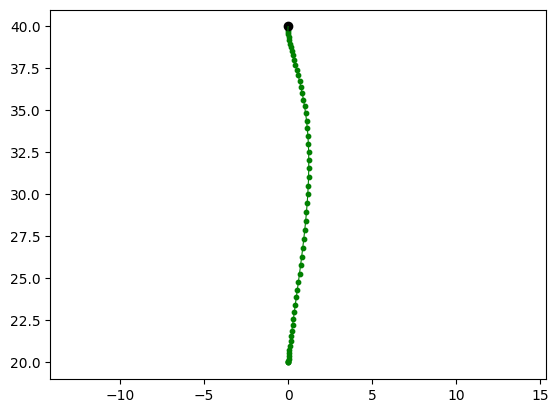

In [96]:
DLQG_6Muscles(Duration = .6,r1 = 1e-5,Num_iter=60,targets = [0,40])

(array([-22.61382074, -22.61382074, -22.56855779, -22.47681864,
        -22.33717923, -22.14812564, -21.90814109, -21.6157703 ,
        -21.26966764, -20.86863268, -20.41163581, -19.8978359 ,
        -19.32659141, -18.69746633, -18.01023217, -17.26486692,
        -16.46155203, -15.60066807, -14.68278999, -13.70868222,
        -12.67929451, -11.59575838, -10.45938492,  -9.27166381,
         -8.0342639 ,  -6.74903539,  -5.41801391,  -4.04342642,
         -2.62769934,  -1.17346915,   0.31640428,   1.83882106,
          3.39042082,   4.96755774,   6.56627026,   8.1822447 ,
          9.81077194,  11.44669645,  13.08435731,  14.71752145,
         16.3392588 ,  17.94199997,  19.51752798,  21.05691857,
         22.55064813,  23.98856215,  25.359585  ,  26.65169236,
         27.85199627,  28.9470173 ,  29.92323935,  30.76805231,
         31.47110779,  32.02565669,  32.43159924,  32.69895048,
         32.84766855,  32.90676187,  32.91234614,  32.90464991]),
 array([31.06691813, 31.06691813, 31.1

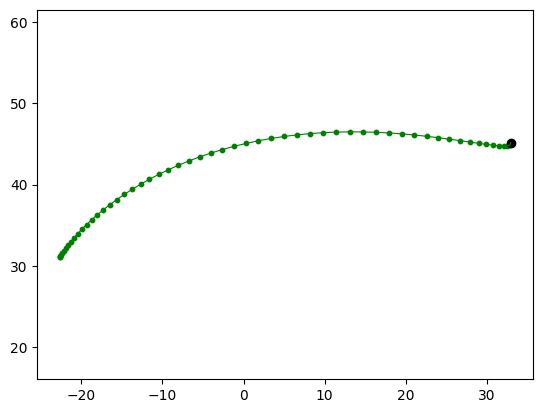

In [99]:
end = ToCartesian(np.array([25 / 180 * pi, 55 / 180 * pi]))
start = ToCartesian(np.array([70 / 180 * pi, 105 / 180 * pi]))

DLQG_6Muscles(Duration = .6,r1 = 1e-5,Num_iter=60,targets = end,starting_point=start)

(array([-15.01886232, -15.01886232, -14.92209952, -14.73412169,
        -14.46109676, -14.10973328, -13.68710874, -13.20044731,
        -12.6568963 , -12.06333077, -11.42619319, -10.75141129,
        -10.04437501,  -9.30995422,  -8.5525366 ,  -7.77606911,
         -6.98409344,  -6.179776  ,  -5.36595081,  -4.54509961,
         -3.71936196,  -2.89054331,  -2.06012273,  -1.22926113,
         -0.3988052 ,   0.43069453,   1.25896747,   2.08601079,
          2.91207695,   3.73766073,   4.56348593,   5.39049145,
          6.21981648,   7.05278435,   7.89088442,   8.73575125,
          9.58914012,  10.45289748,  11.32892502,  12.21913531,
         13.12539672,  14.04977801,  14.99469241,  15.96213489,
         16.9534914 ,  17.96877735,  19.00623827,  20.06290969,
         21.13422202,  22.21322235,  23.29006949,  24.3515294 ,
         25.38053773,  26.35593649,  27.25254981,  28.04184664,
         28.69352744,  29.17859406,  29.47478818,  29.57668051]),
 array([49.40276974, 49.40276974, 49.4

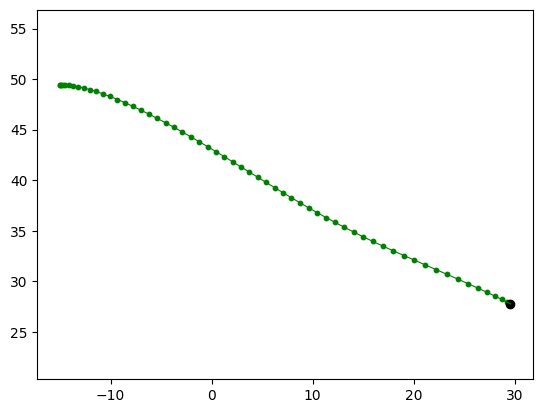

In [100]:
end = ToCartesian(np.array([-10 / 180 * pi, 100 / 180 * pi]))
start = ToCartesian(np.array([70 / 180 * pi, 70 / 180 * pi]))
DLQG_6Muscles(Duration = .6,r1 = 1e-5,Num_iter=60,targets = end,starting_point=start)